## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch with CUDA
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# # Install additional dependencies
# !pip install matplotlib pandas pillow tqdm

# # Install package for creating visually distinct colormaps
# !pip install distinctipy

# # Install utility packages
# !pip install cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
from functools import partial
from pathlib import Path

# Import utility functions
from cjm_pil_utils.core import get_img_files
from cjm_psl_utils.core import download_file, file_extract
from cjm_pytorch_utils.core import tensor_to_pil
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image

# Import PyTorch dependencies
import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.v2  as transforms

# Import tqdm for progress bar
from tqdm.auto import tqdm

## Loading and Exploring the Dataset

### Setting the Directory Paths

In [3]:
# Define path to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Dataset Directory:": dataset_dir, 
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

Dataset Directory:,/mnt/980_1TB_2/Datasets
Archive Directory:,/mnt/980_1TB_2/Datasets/../Archive


### Setting the Dataset Path

In [4]:
# Set the name of the dataset
dataset_name = 'labelme-keypoint-toy-dataset'

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
hf_dataset = f'cj-mills/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

# Creating a Series with the dataset name and paths and converting it to a DataFrame for display
pd.Series({
    "HuggingFace Dataset:": hf_dataset, 
    "Archive Path:": archive_path, 
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

HuggingFace Dataset:,cj-mills/labelme-keypoint-toy-dataset
Archive Path:,/mnt/980_1TB_2/Datasets/../Archive/labelme-keypoint-toy-dataset.zip
Dataset Path:,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset


### Downloading the Dataset

In [5]:
# Construct the HuggingFace Hub dataset URL
dataset_url = f"https://huggingface.co/datasets/{hf_dataset}/resolve/main/{dataset_name}.zip"
print(f"HuggingFace Dataset URL: {dataset_url}")

# Set whether to delete the archive file after extracting the dataset
delete_archive = True

# Download the dataset if not present
if dataset_path.is_dir():
    print("Dataset folder already exists")
else:
    print("Downloading dataset...")
    download_file(dataset_url, archive_dir)    
    
    print("Extracting dataset...")
    file_extract(fname=archive_path, dest=dataset_dir)
    
    # Delete the archive if specified
    if delete_archive: archive_path.unlink()

HuggingFace Dataset URL: https://huggingface.co/datasets/cj-mills/labelme-keypoint-toy-dataset/resolve/main/labelme-keypoint-toy-dataset.zip
Dataset folder already exists


### Getting the Image and Annotation Folders

In [6]:
# Get a list of image files in the dataset
img_file_paths = get_img_files(dataset_path)

# Get a list of JSON files in the dataset
annotation_file_paths = list(dataset_path.glob('*.json'))

# Display the names of the folders using a Pandas DataFrame
pd.DataFrame({"Image File": [file.name for file in img_file_paths], 
              "Annotation File":[file.name for file in annotation_file_paths]}).head()

,Image File,Annotation File
0,133196.jpg,133196.json
1,245035.jpg,245035.json
2,245036.jpg,245036.json
3,247937.jpg,247937.json
4,3172614.jpg,3172614.json


### Get Image File Paths

In [7]:
# Create a dictionary that maps file names to file paths
img_dict = {file.stem : file for file in img_file_paths}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 38


,0
133196,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset/133196.jpg
245035,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset/245035.jpg
245036,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset/245036.jpg
247937,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset/247937.jpg
3172614,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset/3172614.jpg


### Get Image Annotations

In [8]:
# Create a generator that yields Pandas DataFrames containing the data from each JSON file
cls_dataframes = (pd.read_json(f, orient='index').transpose() for f in tqdm(annotation_file_paths))

# Concatenate the DataFrames into a single DataFrame
annotation_df = pd.concat(cls_dataframes, ignore_index=False)

# Assign the image file name as the index for each row
annotation_df['index'] = annotation_df.apply(lambda row: row['imagePath'].split('.')[0], axis=1)
annotation_df = annotation_df.set_index('index')

# Keep only the rows that correspond to the filenames in the 'img_dict' dictionary
annotation_df = annotation_df.loc[list(img_dict.keys())]

# Print the first 5 rows of the DataFrame
annotation_df.head()

  0%|          | 0/38 [00:00<?, ?it/s]

,version,flags,shapes,imagePath,imageData,imageHeight,imageWidth
index,,,,,,,
133196,5.3.1,{},"[{'label': 'nose', 'points': [[386.70731707317077, 297.109756097561]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]",133196.jpg,None,768,960
245035,5.3.1,{},"[{'label': 'nose', 'points': [[334.4587155963303, 319.57798165137615]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]",245035.jpg,None,1152,768
245036,5.3.1,{},"[{'label': 'nose', 'points': [[226.8571428571429, 240.80357142857144]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]",245036.jpg,None,1120,768
247937,5.3.1,{},"[{'label': 'nose', 'points': [[454.6585365853659, 230.03658536585363]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]",247937.jpg,None,768,1152
3172614,5.3.1,{},"[{'label': 'nose', 'points': [[539.4146341463414, 608.0853658536585]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]",3172614.jpg,None,768,1152


### Inspecting the Class Distribution

#### Get image classes

In [9]:
# Explode the 'shapes' column in the annotation_df dataframe
# Convert the resulting series to a dataframe and rename the 'shapes' column to 'shapes'
# Apply the pandas Series function to the 'shapes' column of the dataframe
shapes_df = annotation_df['shapes'].explode().to_frame().shapes.apply(pd.Series)

# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = shapes_df['label'].unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,nose


#### Visualize the class distribution

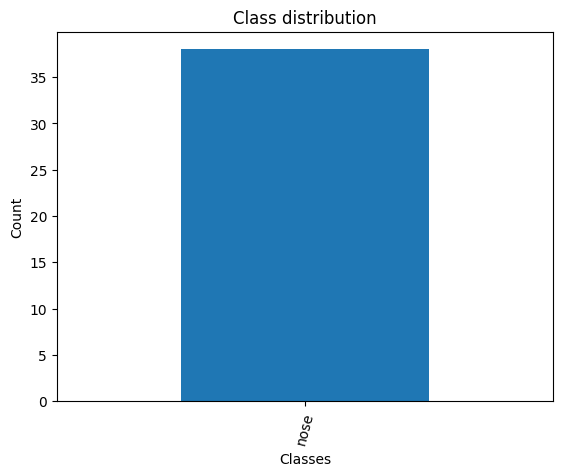

In [10]:
# Get the number of samples for each object class
class_counts = shapes_df['label'].value_counts()

# Plot the distribution
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_counts.index, rotation=75)  # Set the x-axis tick labels
plt.show()

### Visualizing Keypoint Annotations

#### Generate a color map

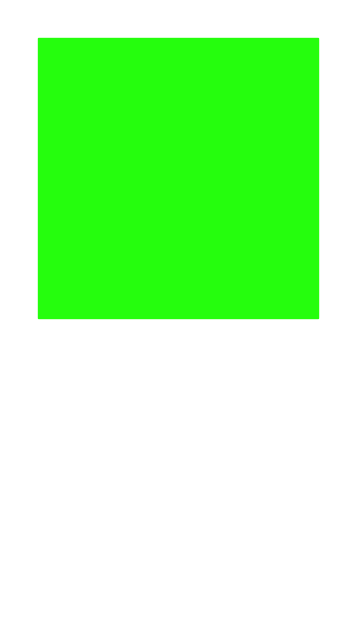

In [11]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

#### Download a font file

In [12]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


#### Define the bounding box annotation function

In [13]:
draw_bboxes = partial(draw_bounding_boxes, fill=True, width=4, font=font_file, font_size=25)

### Selecting a Sample Image

#### Load the sample image

Image Dims: (960, 768)


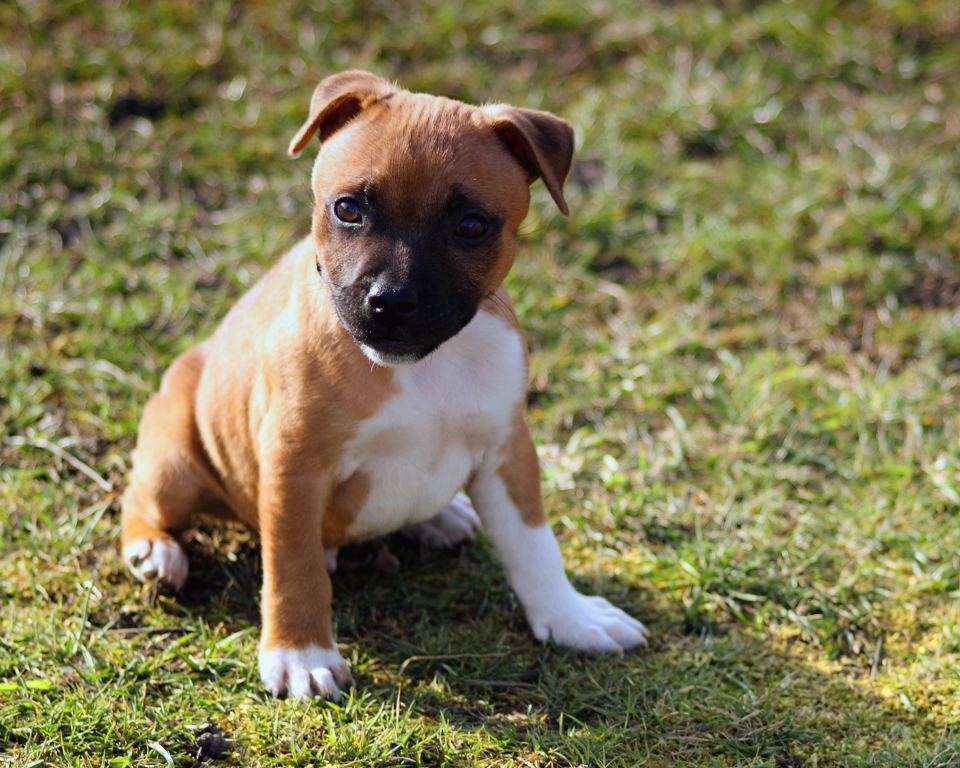

In [14]:
# Get the file ID of the first image file
file_id = list(img_dict.keys())[0]

# Open the associated image file as a RGB image
sample_img = Image.open(img_dict[file_id]).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

#### Inspect the corresponding annotation data

In [15]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc[file_id].to_frame()

,133196
version,5.3.1
flags,{}
shapes,"[{'label': 'nose', 'points': [[386.70731707317077, 297.109756097561]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]"
imagePath,133196.jpg
imageData,None
imageHeight,768
imageWidth,960


#### Annotate sample image

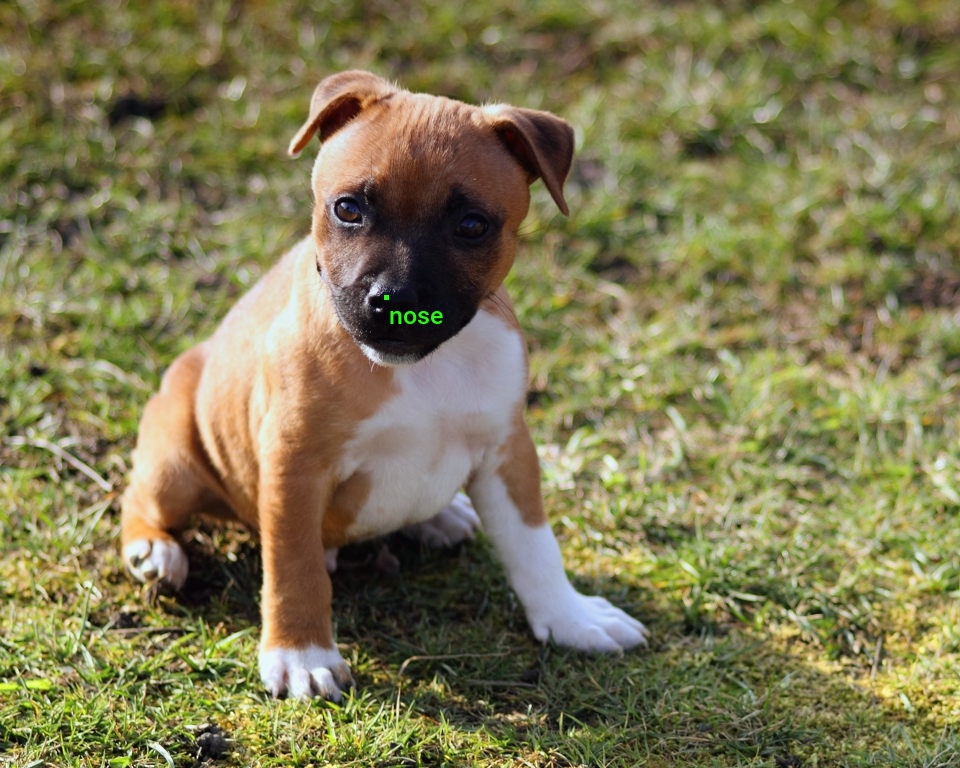

In [16]:
# Extract the labels and bounding box annotations for the sample image
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
keypoints = torch.tensor(np.array([shape['points'] for shape in annotation_df.loc[file_id]['shapes']])).reshape(1,2)
keypoints_bboxes = torch.cat((keypoints, torch.ones(len(keypoints), 2)*4), dim=1)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(sample_img), 
    boxes=torchvision.ops.box_convert(torch.Tensor(keypoints_bboxes), 'cxcywh', 'xyxy'),
    labels=labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

## Preparing the Data

### Data Augmentation

#### Set training image size

In [17]:
# Set training image size
train_sz = 384

#### Initialize custom transforms

In [18]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400, 
                               jitter_factor=0.25)

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True)

#### Test the transforms

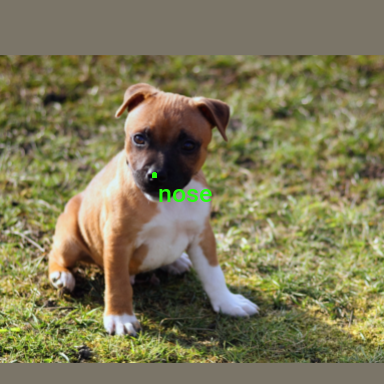

Source Image:,"(960, 768)"
Cropped Image:,"(960, 768)"
Resized Image:,"(383, 307)"
Padded Image:,"(383, 383)"
Resized Padded Image:,"(384, 384)"


In [19]:
# Prepare bounding box targets
targets = {'boxes': BoundingBoxes(torchvision.ops.box_convert(keypoints_bboxes, 'cxcywh', 'xyxy'), 
                                format='xyxy', 
                                canvas_size=sample_img.size[::-1]), 
           'labels': labels}

# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(resized_padded_img), 
    boxes=targets['boxes'], 
    labels=targets['labels'], 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [20]:
class LabelMeKeypointDataset(Dataset):
    """
    A PyTorch Dataset class for handling LabelMe image keypoints.
    
    This class extends PyTorch's Dataset and is designed to work with image data and
    associated keypoints annotations. It supports loading images and corresponding
    keypoints annotations, and applying transformations.

    Attributes:
        img_keys (list): List of image keys.
        annotation_df (DataFrame): DataFrame containing annotations for each image.
        img_dict (dict): Dictionary mapping image keys to their file paths.
        class_to_idx (dict): Dictionary mapping class names to class indices.
        transforms (callable, optional): Transformations to be applied to the images and targets.
    """

    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        """
        Initializes the LabelMeKeypointDataset with image keys, annotations, and other relevant information.
        
        Args:
            img_keys (list): List of image keys.
            annotation_df (DataFrame): DataFrame containing annotations for each image.
            img_dict (dict): Dictionary mapping image keys to their file paths.
            class_to_idx (dict): Dictionary mapping class names to class indices.
            transforms (callable, optional): Transformations to be applied to the images and targets.
        """
        super(Dataset, self).__init__()
        
        self._img_keys = img_keys
        self._annotation_df = annotation_df
        self._img_dict = img_dict
        self._class_to_idx = class_to_idx
        self._transforms = transforms

        self.BBOX_DIM = 4

    def __len__(self):
        """
        Returns the number of items in the dataset.
        
        Returns:
            int: Number of items in the dataset.
        """
        return len(self._img_keys)
        
    def __getitem__(self, index):
        """
        Retrieves an item from the dataset at the specified index.
        
        Args:
            index (int): Index of the item to retrieve.

        Returns:
            tuple: A tuple containing the image and its corresponding target (annotations).
        """
        img_key = self._img_keys[index]
        annotation = self._annotation_df.loc[img_key]
        image, target = self._load_image_and_target(annotation)
        
        # Applying transformations if specified
        if self._transforms:
            image, target = self._transforms(image, target)
        
        return image, target

    def _load_image_and_target(self, annotation):
        """
        Loads an image and its corresponding target (annotations) based on the provided annotation.
        
        Args:
            annotation (DataFrame row): Annotation data for a specific image.
            Returns:
        tuple: A tuple containing the loaded image and its corresponding target data.
        """
        # Load the image from the file path specified in the annotations
        filepath = self._img_dict[annotation.name]
        image = Image.open(filepath).convert('RGB')

        # Extracting keypoints from the annotation and converting them to a tensor
        keypoints = torch.tensor(np.array([shape['points'] for shape in annotation['shapes']])).reshape(-1, 2)
        # Adding an offset to create bounding boxes around keypoints
        keypoints_bboxes = torch.cat((keypoints, torch.ones(len(keypoints), 2) * self.BBOX_DIM), dim=1)
                
        # Convert bounding box format and create a BoundingBoxes object
        bbox_tensor = torchvision.ops.box_convert(keypoints_bboxes, 'cxcywh', 'xyxy')
        boxes = BoundingBoxes(bbox_tensor, format='xyxy', canvas_size=image.size[::-1])
        
        # Create tensor for labels based on the class indices
        labels = torch.Tensor([self._class_to_idx[label] for label in class_to_idx.keys()])
        
        return image, {'boxes': boxes, 'labels': labels}

### Image Transforms

In [21]:
# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose(
    transforms=[
        iou_crop,
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max, 
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms, 
    resize_pad_tfm, 
    final_tfms
])

### Initialize Dataset

In [22]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the dataset using the defined transformations
train_dataset = LabelMeKeypointDataset(list(img_dict.keys()), annotation_df, img_dict, class_to_idx, train_tfms)

# Print the number of samples in the training dataset
pd.Series({
    'Training dataset size:': len(train_dataset),
}).to_frame().style.hide(axis='columns')

Training dataset size:,38


### Inspect Samples

**Inspect training set sample**

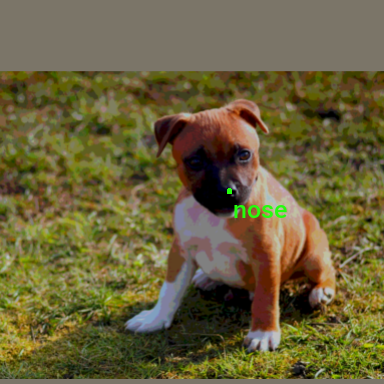

In [23]:
dataset_sample = train_dataset[0]

annotated_tensor = draw_bboxes(
    image=(dataset_sample[0]*255).to(dtype=torch.uint8), 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=[int_colors[int(i.item())] for i in dataset_sample[1]['labels']]
)

tensor_to_pil(annotated_tensor)